---
<p style="text-align: center;font-size: 2em;font-weight: bold;">
Projet numérique de Probabilités 2025/26
</p>

---


# Introduction

On va s'intéresser à la simulation de champs aléatoires gaussiens. On peut définir un champ aléatoire Gaussien comme une collection de variables aléatoires indexées par un ensemble telles que toute combinaison linéaire finie de ces variables aléatoires suit une loi normale. Pour simplifier, nous nous intéresserons à des champs aléatoires gaussiens définis sur une grille régulière de points dans un domaine  $\mathbb{R}^2$. 

Un champ aléatoire Gaussien est entièrement caractérisé par son espérance et sa fonction de covariance. L'espérance est une fonction qui attribue à chaque point du domaine la valeur moyenne de la variable aléatoire associée à ce point. La fonction de covariance est une fonction qui décrit comment les variables aléatoires associées à deux points différents du domaine sont corrélées entre elles. 

Un exemple classique de fonction de covariance est la fonction exponentielle quadratique (ou gaussienne) définie par :
$$C(x, y) = \sigma^2 \exp\left(-\frac{\|x - y\|^2}{a}\right)$$
où  $\sigma^2$ est la variance,  $a$ est le facteur d'échelle, et $\|x - y\|$ est la distance euclidienne entre les points  $x$ et $y$.
Une telle fonction de covariance implique que les points proches dans le domaine ont des valeurs de champ aléatoire fortement corrélées, tandis que les points éloignés ont des valeurs faiblement corrélées. Elle est souvent utilisée pour modéliser des phénomènes naturels où la corrélation diminue avec la distance. 

Dans ce projet, nous allons implémenter une méthode pour simuler des champs aléatoires gaussiens sur une grille régulière de points dans un domaine  $\mathbb{R}^2$. Nous utiliserons dans un premier temps la méthode de la décomposition de Cholesky pour générer des échantillons de champs aléatoires gaussiens à partir de leur fonction de covariance. Dans un second temps, nous explorerons un méthode plus efficace basée sur la représentation spectrale de la fonction de covariance. Enfin, nous verrons comment conditionner ces simulations sur des observations ponctuelles.

# Simulation par la méthode de Cholesky

Quitte à réarranger les points de la grille, on peut supposer que l'on a une liste finie de points  $x_1, x_2, \ldots, x_n$ dans  $\mathbb{R}^2$ où l'on souhaite simuler le champ aléatoire Gaussien. La fonction de covariance  $C$ permet de construire la matrice de covariance  $K$ définie par :

$$K_{ij} = C(x_i, x_j)$$

On va implementer la méthode de Cholesky pour générer des réalisations de champs aléatoires gaussiens à partir de cette matrice de covariance.

1. Ecrire une fonction "covariance_gaussienne" qui prend en entrée une matrice de distances, ainsi que les paramètres  $\sigma^2$ et  $a$, et qui retourne la valeur de la fonction de covariance gaussienne entre ces deux points.

In [2]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from matplotlib import cm
import time



def covariance_gaussienne(D, sigma2, a):
    return sigma2 * np.exp(-D**2 / a) 


2. Discrétiser le domaine  $[0, 1] \times [0, 1]$ en une grille régulière de  $n \times n$ points (par exemple,  $n = 50$). Construire la matrice de distances entre tous les points de la grille.

In [9]:
n = 50

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(x, y)
M = np.column_stack((X.flatten(), Y.flatten()))

D = distance_matrix(M, M)
print(D.shape)
print(D)

(2500, 2500)
[[0.         0.02040816 0.04081633 ... 1.38565267 1.3998572  1.41421356]
 [0.02040816 0.         0.02040816 ... 1.3716047  1.38565267 1.3998572 ]
 [0.04081633 0.02040816 0.         ... 1.35771815 1.3716047  1.38565267]
 ...
 [1.38565267 1.3716047  1.35771815 ... 0.         0.02040816 0.04081633]
 [1.3998572  1.38565267 1.3716047  ... 0.02040816 0.         0.02040816]
 [1.41421356 1.3998572  1.38565267 ... 0.04081633 0.02040816 0.        ]]


3. Utiliser la fonction "covariance_gaussienne" pour construire la matrice de covariance $K$ en évaluant la fonction de covariance pour chaque paire de points dans la grille puis calculer la décomposition de Cholesky de $K$ (voir *np.linalg.cholesky*).

On choisira ici  $\sigma^2 = 1$ et  $a = 0.05$.

NB : Pour assurer la stabilité numérique, on peut ajouter un petit terme de régularisation à la diagonale de la matrice de covariance avant de calculer la décomposition de Cholesky (par exemple,  $10^{-10} I$ où  $I$ est la matrice identité).

In [3]:
sigma2 = 1.0
a = 0.05

K = covariance_gaussienne(D, sigma2, a)

L = np.linalg.cholesky(K + 1e-10 * np.eye(n**2))  # on calucule la matrice de Cholesky de K
print(L.shape)
print(L)

(2500, 2500)
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.91704735e-01 1.28536841e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.67229528e-01 2.52835152e-01 2.32685435e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.10282187e-17 1.92747629e-16 1.21630234e-15 ... 2.33217283e-05
  0.00000000e+00 0.00000000e+00]
 [9.53079697e-18 9.00635347e-17 5.86167316e-16 ... 3.60090019e-05
  2.74380495e-05 0.00000000e+00]
 [4.24835426e-18 4.13708933e-17 2.77588021e-16 ... 4.49445638e-05
  5.00271321e-05 4.33673357e-05]]


4. Générer et représenter une réalisation du champ aléatoire Gaussien centré et de covariance $K$.

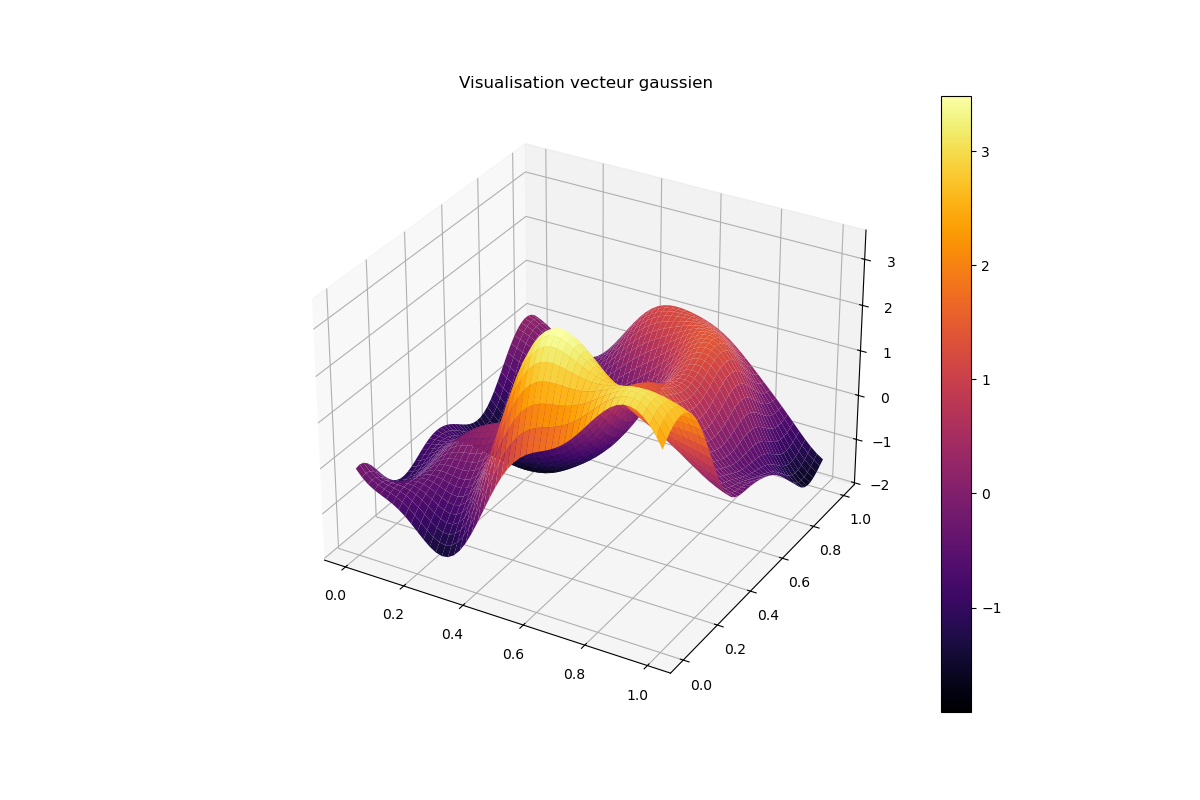

In [10]:
%matplotlib widget

# On génère une suite d'élément d'une VA normale centrée réduite
B = np.random.normal(0, 1, size=len(K))

# On corrèle le bruit blanc en multipliant par la matrice de Cholesky
Z = L @ B

# Graphique
Z_surface = Z.reshape(n, n)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z_surface, cmap=cm.inferno, linewidth=0)

fig.colorbar(surf)

plt.title("Visualisation vecteur gaussien")
plt.show()

5. Essayer d'augmenter le nombre de pas de discrétisation. Que remarquez-vous ? Expliquer pourquoi.

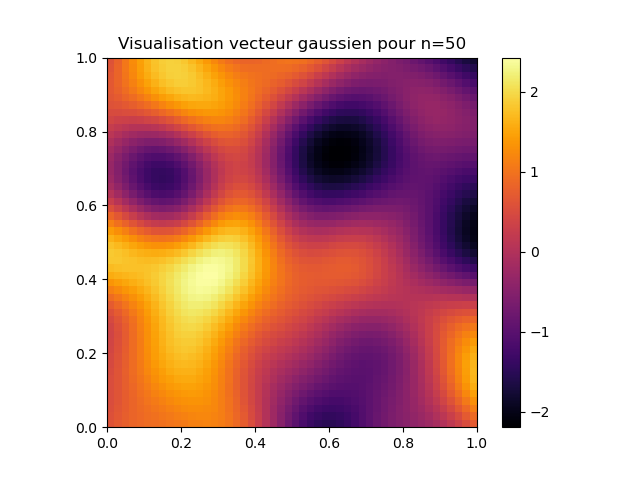

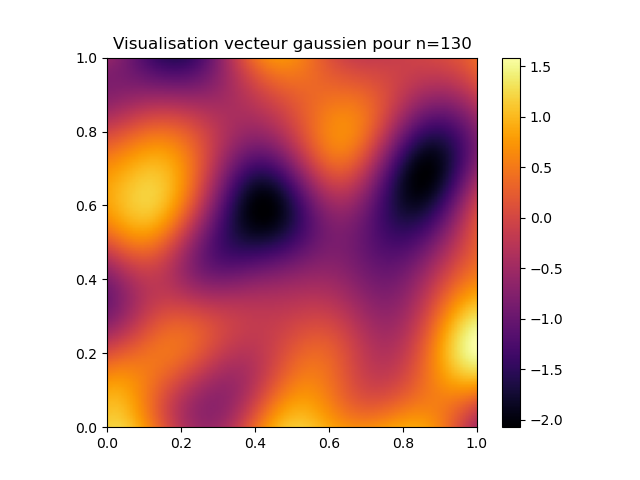

In [12]:
sigma2 = 1.0
a = 0.05

# on affichera qu'en 2D car mon ordinateur n'est pas assez puissant
pas = [50, 70, 90, 110, 130]
temps_calcul = []

for p in pas:
    start_time = time.time()

    x_p = np.linspace(0, 1, p)
    y_p = np.linspace(0, 1, p)
    X_p, Y_p = np.meshgrid(x_p, y_p)


    M_p = np.column_stack((X_p.flatten(), Y_p.flatten()))

    D_p = distance_matrix(M_p, M_p)

    K_p = covariance_gaussienne(D_p, sigma2, a)

    L_p = np.linalg.cholesky(K_p + 1e-10 * np.eye(p**2))  # on calucule la matrice de Cholesky de K_p

    B_p = np.random.normal(0, 1, size=len(K_p))
    Z_p = L_p @ B_p
    Z_surface_p = Z_p.reshape(p, p)

    end_time = time.time()
    temps_calcul.append(end_time - start_time)

    if p in [50, 130]:  # on affiche pour quelques valeurs de p
        plt.figure()
        plt.imshow(Z_surface_p, extent=(0, 1, 0, 1), origin='lower', cmap=cm.inferno)
        plt.colorbar()      
        plt.title(f"Visualisation vecteur gaussien pour n={p}")
        plt.show()

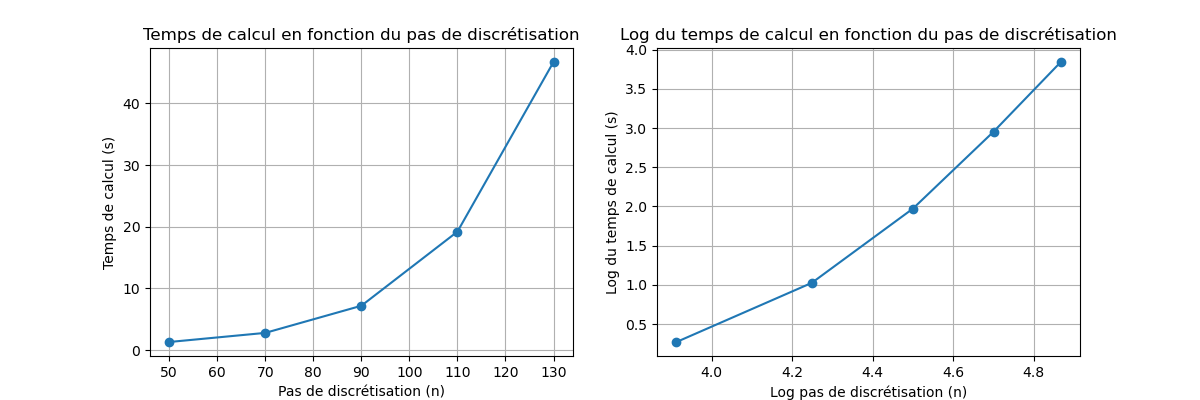

In [13]:
pas_arr = np.array(pas)
temps_arr = np.array(temps_calcul)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(pas_arr, temps_arr, 'o-')
axs[0].set_title("Temps de calcul en fonction du pas de discrétisation")
axs[0].set_xlabel("Pas de discrétisation (n)")
axs[0].set_ylabel("Temps de calcul (s)")
axs[0].grid(True)


log_pas = np.log(pas_arr)
log_temps = np.log(temps_arr)


axs[1].plot(log_pas, log_temps, 'o-')
axs[1].set_title("Log du temps de calcul en fonction du pas de discrétisation")
axs[1].set_xlabel("Log pas de discrétisation (n)")
axs[1].set_ylabel("Log du temps de calcul (s)")
axs[1].grid(True)


plt.show()


On remarque donc que le temps de calcul, comme la taille des matrice calculées, est exponetiel, car le log du temps de calcul est linéaire.
C'est pourquoi, quand on augmente n, le kernel crash.

# Simulation par la méthode spectrale 

Vu les limitations de la méthode de Cholesky pour des grilles fines, nous allons explorer une méthode alternative basée sur la représentation spectrale de la fonction de covariance. 

1. Soit $C(h) = \exp\left(-\frac{\|h\|^2}{a}\right)$, où $h \in \mathbb{R}^2$. Montrer que :
$$ C(h) = \int_{\mathbb{R}^2} \cos(\langle w, h \rangle) \frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right) dw $$

NB: on pourra s'inspirer du calcul de la fonction caractéristique d’un vecteur gaussien en annexe du chapitre IV du cours.

$$ \int_{\mathbb{R}^2} \cos(\langle w, h \rangle)
\frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right) dw $$    
dérivable par théorème de dérivation des intégrales à paramètres puisque l'intégrande est dérivable par rapport à h (composition par produit scalaire et cos qui le sont) et la dérivée par rapport à h est intégrable qrâce à l'exponentielle.

D'où:

$$\nabla C(h) = \int_{\mathbb{R}^2} -w\sin(\langle w, h \rangle) \frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right) dw $$

Par intégration par partie en dimension 2, avec :

$u(w)=\sin(\langle w, h \rangle)$, $\nabla v(w)=\frac{-w.a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right)$

$\nabla u(w)=h\cos(\langle w, h \rangle)$, $v(w)=\frac{1}{2\pi}\exp\left(-\frac{a\|w\|^2}{4}\right) $

On a, avec les crochets qui s'annulent en raison de l'exponentielle en $ \pm\infty $:

$$\nabla C(h) = -\frac{1}{2\pi}\int_{\mathbb{R}^2} h\cos(\langle w, h \rangle) \exp\left(-\frac{a\|w\|^2}{4}\right) dw$$
$$\nabla C(h) = -\frac{2}{a} h C(h) $$

Solution d'une équation différentielle résolue en annexe du chapitre 4, doù:

$$C(h)=C\exp\left(-\frac{\|h\|^2}{a}\right)$$

C(0)=1 donc:

$$C(h)=\exp\left(-\frac{\|h\|^2}{a}\right)$$

2. Soient $W$ et $\Phi$ deux variables aléatoires indépendantes, de lois respectives $\mathcal{N}(0, \frac{2}{a} I_2)$, avec $I_2$ la matrice identité de dimension 2, et $\mathcal{U}[0, 2\pi[$. Montrer que la variable aléatoire définie en tout point $x \in \mathbb{R}^2$ par :
$$ Z(x) = \sqrt{2} \cos(\langle W, x \rangle + \Phi) $$
est d'espérance nulle et de fonction de covariance $C$.

- Calcul de l'espérance :

Comme $\cos(a+b) = \cos(a)\cos(b) - \sin(a)\sin(b)$ :
$$Z(x) = \sqrt{2} \left( \cos(\langle W, x \rangle)\cos(\Phi) - \sin(\langle W, x \rangle)\sin(\Phi) \right)$$

Par linéarité de l'espérance :
$$E[Z(x)] = \sqrt{2} \left( E[\cos(\langle W, x \rangle)\cos(\Phi)] - E[\sin(\langle W, x \rangle)\sin(\Phi)] \right)$$

Puisque $W$ et $\Phi$ sont indépendantes, toute fonction de $W$ est indépendante de toute fonction de $\Phi$ :
$$E[Z(x)] = \sqrt{2} \left( E[\cos(\langle W, x \rangle)] \cdot E[\cos(\Phi)] - E[\sin(\langle W, x \rangle)] \cdot E[\sin(\Phi)] \right)$$

Comme $\Phi$ suit $\mathcal{U}[0, 2\pi[$, $f_{\Phi}(\phi) = \frac{\mathbb{1}_{[0, 2\pi[}(x)}{2\pi}$ :
$$E[\cos(\Phi)] = \int_{0}^{2\pi} \cos(\phi) \frac{1}{2\pi} \, \mathrm{d}\phi = 0$$$$E[\sin(\Phi)] = \int_{0}^{2\pi} \sin(\phi) \frac{1}{2\pi} \, \mathrm{d}\phi = 0$$

Donc :
$$E[Z(x)] = 0$$

- Calcul de la covariance :
$$Cov(Z(x), Z(y)) = E[Z(x)Z(y)] - E[Z(x)]E[Z(y)]$$
Z étant centrée :
$$Cov(Z(x), Z(y)) = E[Z(x)Z(y)]$$
$$Cov(Z(x), Z(y)) = 2E\left[\cos(\langle W, x \rangle + \Phi)\cos(\langle W, y \rangle + \Phi)\right]$$

Comme $\cos(a)\cos(b) = \frac{1}{2} \left[ \cos(a-b) + \cos(a+b) \right]$ :
$$Cov(Z(x), Z(y)) = E\left[\cos(\langle W, x \rangle - \langle W, y \rangle) + \cos(\langle W, x \rangle + \langle W, y \rangle + 2\Phi)\right]$$

Par le même argument que pour l'espérance nulle et bilinéarité du produit scalaire :
$$Cov(Z(x), Z(y)) = E\left[\cos(\langle W, x -y \rangle)\right]$$

Comme $W \sim \mathcal{N}(0, \frac{2}{a} I_2)$ : $f_W(w) = \frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right)$

$$Cov(Z(x), Z(y)) = \int_{\mathbb{R}^2}\cos(\langle w, x -y \rangle)\frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right)dw $$

Donc :
$$Cov(Z(x), Z(y)) = C(x-y)$$

3. Soient les suites de variables aléatoires indépendantes $(W_n)_{n \in \mathbb{N}}$ et $(\Phi_n)_{n \in \mathbb{N}}$ telles que $W_n \sim \mathcal{N}(0, \frac{2}{a} I_2)$ et $\Phi_n \sim \mathcal{U}([0, 2\pi])$. Montrer que pour tout ensemble fini de points  $x_1, \ldots, x_n$ dans  $\mathbb{R}^2$ , le vecteur aléatoire $Y = (Y(x_1), \ldots, Y(x_n))$ où :
$$ Y(x_i) = \sqrt{\frac{2}{N}} \sum_{k=1}^{N} \cos(\langle W_k, x_i \rangle + \Phi_k) $$
tend vers un vecteur aléatoire de loi normale multivariée d'espérance nulle et de matrice de covariance $K$ définie par  $K_{ij} = C(x_i - x_j)$.

On pose $Z_k = \sqrt{2}(\cos(\langle W_k, x_1 \rangle + \Phi_k),...,\cos(\langle W_k, x_n \rangle + \Phi_k)) $

On a alors $Y=\frac{1}{\sqrt{N}} \sum_{k=1}^{N} Z_k$

Les $Z_k$ sont indépendantes identiquement distribuées par propriétés des $W_k$ et des $\Phi_k$.

Par Q2, $Cov(Z_k(x_i),Z_k(x_j))=C(x_i-x_j)=K_{ij}$

De plus, par Q2, $E(Z_k)=0 $

Ainsi, par Théorème Central Limite, Y converge en loi vers $Y_\infty$ ~ $\mathcal{N}(0,K)$

4. Implémenter une fonction basée sur cette méthode pour simuler un champ aléatoire gaussien sur une grille régulière de points dans le domaine  $[0, 1] \times [0, 1]$. Cette fonction prendra en entrée les coordonnées des points de la grille, $a$ et  $N$ et retournera une réalisation du champ aléatoire gaussien simulé.

In [14]:
def champ_gaussien(L_x,L_y,a,N): #Lx et Ly vect. numpy

    M = np.zeros((len(L_x),len(L_y)))
    W = np.random.normal(0,np.sqrt(2/a),size=(N,2))
    Phi = np.random.uniform(0,2*np.pi,size=N)

    for i in range(len(L_x)):
        for j in range(len(L_y)):
            point = np.array([L_x[i],L_y[j]])
            somme = 0.0
            for k in range(N):
                somme += np.cos(np.dot(W[k], point) + Phi[k])
            M[i,j] = np.sqrt(2/N)*somme

    return M

In [57]:
def champ_gaussien_vectorise(L_x, L_y, a, N): #Lx et Ly vect. numpy
    X, Y = np.meshgrid(L_x, L_y)
    
    W = np.random.normal(0, np.sqrt(2/a), size=(N, 2))
    Phi = np.random.uniform(0, 2*np.pi, size=N)

    # On transforme les vecteurs (N) en cubes (N, 1, 1) pour qu'ils s'appliquent à toute la grille
    Wx = W[:, 0].reshape(-1, 1, 1)
    Wy = W[:, 1].reshape(-1, 1, 1)
    P  = Phi.reshape(-1, 1, 1)

    argument = (Wx * X) + (Wy * Y) + P
    
    # Somme sur l'axe 0 (l'axe des ondes N)
    somme = np.sum(np.cos(argument), axis=0)

    return np.sqrt(2/N) * somme

5. Tester cette fonction pour différentes valeurs du nombre de points de discrétisation et de $N$. Proposer un diagnostic permettant de calibrer $N$ afin que les résultats soient conformes aux attentes. Comparer les résultats obtenus avec ceux de la méthode de Cholesky. Quels sont les avantages et les inconvénients de chaque méthode ?

Regardons juste un point : $ Y(x_i) = \sqrt{\frac{2}{N}} \sum_{k=1}^{N} \cos(\langle W_k, x_i \rangle + \Phi_k) $

Alors avec : $X_k = \cos(\langle W_k, x_i \rangle + \Phi_k)$

On a : $E[X_k] = 0$ par Q2

Ensuite : $E[X_k^2] = E[ \cos^2(\langle W_k, x_i \rangle + \Phi_k)]$ 

Comme $\cos^2(\theta) = \frac{1 + \cos(2\theta)}{2}$ :
$$E[X_k^2] = E[\frac{1}{2} + \frac{1}{2}\cos(2(\mathbf{W}_k \cdot \mathbf{x} + \Phi_k))]$$

De même que dans la Q2, $E[\frac{1}{2}\cos(2(\mathbf{W}_k \cdot \mathbf{x} + \Phi_k))] = 0$, d'où : 
$$E[X_k^2] = \frac{1}{2} \text{  ie  } Var(X_k) =\frac{1}{\sqrt{2}} $$

Finalement comme les $X_k$ sont iid, par le Théorème Central Limite : 
$Y(x_i)$ converge en loi vers $\mathcal{N}(0,1)$

On vérifira donc que l'ensemble des points suit une loi normale réduite centrée

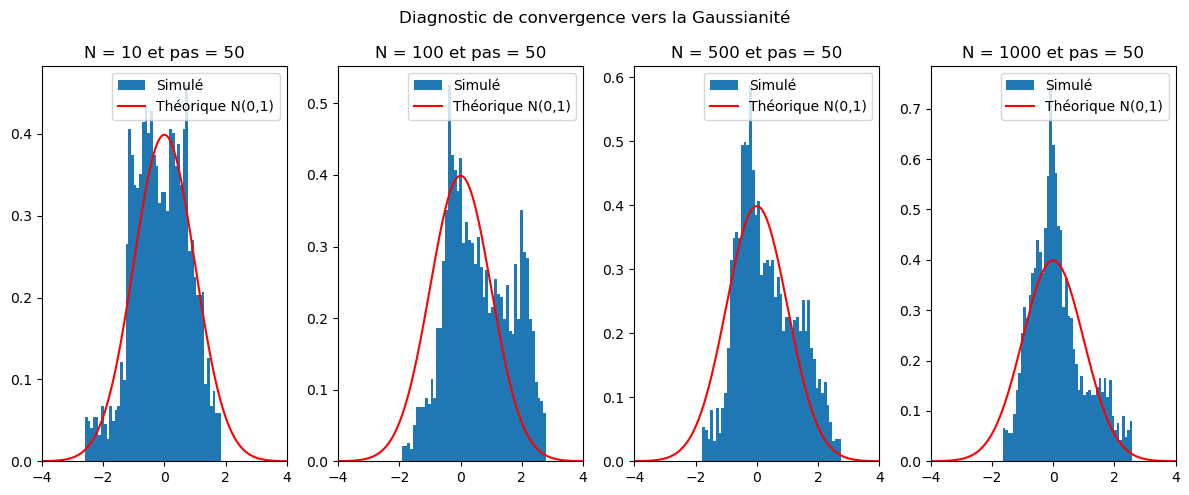

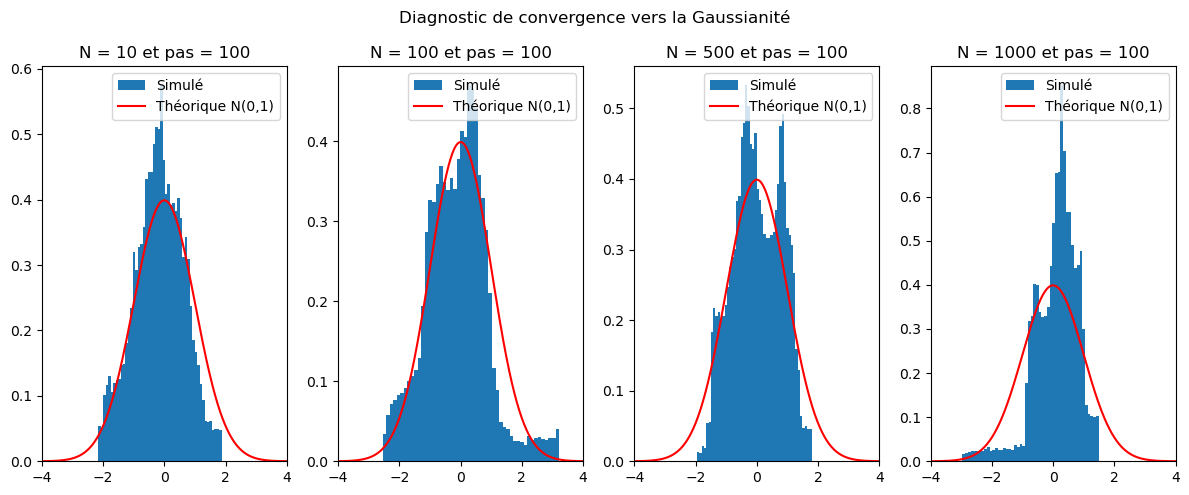

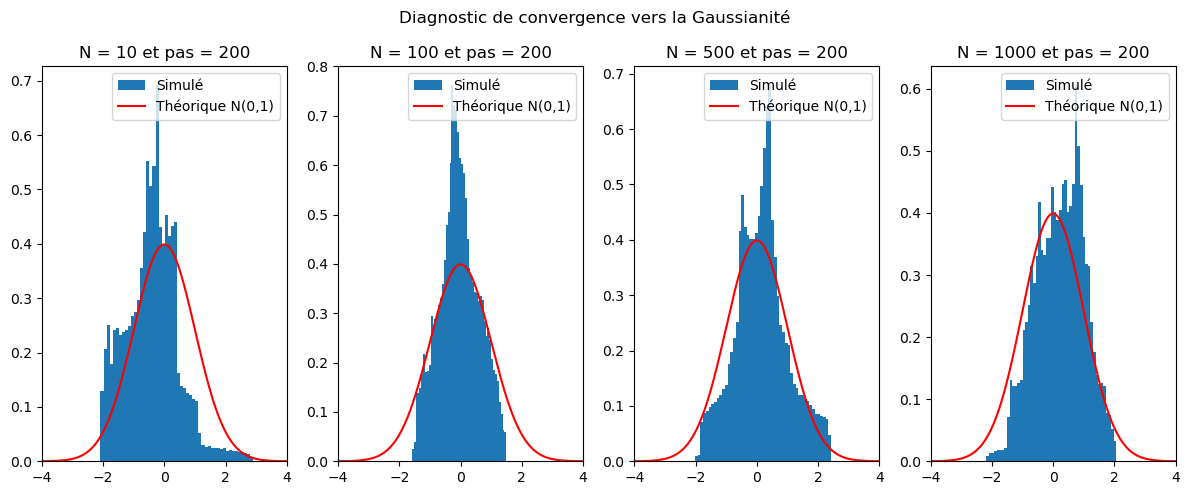

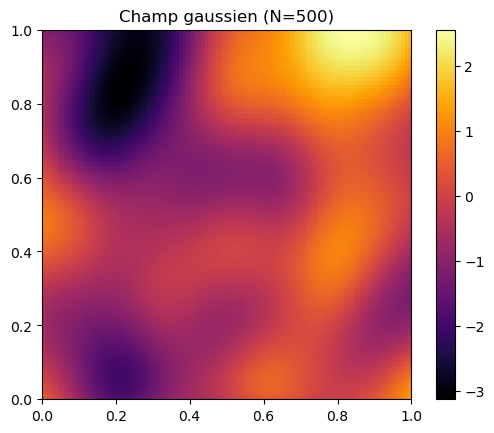

In [58]:
from scipy.stats import norm

a = 0.05  # Paramètre de corrélation

# on teste différents pas de discrétisation et différents N
pas_test = [50, 100, 200]
N_test = [10, 100, 500, 1000]

for p in pas_test:
    L_x = np.linspace(0, 1, p)
    L_y = np.linspace(0, 1, p)

    plt.figure(figsize=(12, 5))

    for k in range(len(N_test)):
        N = N_test[k]
        M = champ_gaussien_vectorise(L_x, L_y, a, N)
        
        plt.subplot(1, len(N_test), k+1)
        
        # On aplatit M pour avoir toutes les valeurs en 1D
        valeurs = M.flatten()
        
        # On trace l'histogramme
        plt.hist(valeurs, bins=50, density=True, label='Simulé')
        
        # Tracer la Gaussienne théorique N(0, 1)
        x_g = np.linspace(-4, 4, 400)
        y_g = norm.pdf(x_g, 0, 1)
        plt.plot(x_g, y_g, 'r-', label='Théorique N(0,1)')
        
        plt.title(f"N = {N} et pas = {p}")
        plt.xlim(-4, 4)
        plt.legend()

    plt.suptitle("Diagnostic de convergence vers la Gaussianité")
    plt.tight_layout()
    plt.show()

# On visualise le champ pour N = 500 et pas = 100
M_final = champ_gaussien_vectorise(np.linspace(0, 1, 100), np.linspace(0, 1, 100), a, 500)
plt.figure()
plt.imshow(M_final, extent=[0, 1, 0, 1], origin='lower', cmap='inferno')
plt.colorbar()
plt.title(f"Champ gaussien (N=500)")
plt.show()

On calcule plusieurs champs gaussiens allant jusqu'à N = 1500 en qq secondes, là où il fallait plusieurs minutes avec la méthode de Cholesky, qui est donc bien moins optimisée.
Ensuite pour le choix de N, il faut en prendre un assez grand, car on simule une convergence mais il ne faut pas qu'il soit trop grand, pour éviter de faire trop d'itérations.

# Simulation conditionnelle 

On suppose désormais que l'on dispose de valeurs observées du champ aléatoire Gaussien en certains points du domaine. On souhaite simuler des réalisations conditionnelles du champ aléatoire Gaussien en tenant compte de ces observations. On travaillera désormais avec une grille de taille $100 \times 100$.
Soit $X$ un vecteur aléatoire Gaussien partitionné en deux sous-vecteurs $X_1$ et $X_2$, où $X_1$ représente les points observés et $X_2$ les points non observés. 

1. Rappeler l'expression de la distribution jointe de $X = (X_1, X_2)$ puis de la distribution conditionnelle de $X_2$ sachant $X_1$. Montrer que la différence entre l'espérance conditionnelle et le vecteur des points non observés est un vecteur Gaussien d'espérance nulle indépendant du vecteur des points non observés.

- Distribution jointe:

$$X = \begin{pmatrix} X_1 \\ X_2 \end{pmatrix} \sim \mathcal{N}\left( \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{pmatrix} K_{11} & K_{12} \\ K_{21} & K _{22} \end{pmatrix} \right)$$

Avec $K_{11}$ Matrice de covariance de $X_1$, $K_{22}$ celle de $X_2$, $K_{12}$ celle de $X_1$ par rapport à $X_2$ et $K_{21}$ sa transposée.

- Distribution conditionnelle:

$X_2 | (X_1 =x_1)$ ~ $\mathcal{N}( K_{21}K_{11}^{-1}x_1, K_{22} - K_{21}K_{11}^{-1}K_{12}) $

Notons $\epsilon = E[X_2 | X_1 ] - X_2 $

Par linéarité de l'espérance et formule de l'espérance totale:

$$E(\epsilon) = E[X_2] - E[X_2] = 0$$

De plus, il s'agit d'un vecteur gaussien par combinaison linéaire de vecteurs gaussiens car $E[X_2 | X_1] = K_{21}K_{11}^{-1}X_1$

Pour l'indépendance, il suffit que la covariance entre epsilon et X2 soit nulle. Or celle-ci ne l'est pas, on veut sûrment parler de l'indépendance vis-à-vis des points observés : 

$$Cov(\epsilon,X_2)=Cov(K_{21}K_{11}^{-1}X_1-X_2,X_2)$$

Par bilinéarité de la covariance:

$$Cov(\epsilon,X_2)=K_{21}K_{11}^{-1}Cov(X_1,X_2)-Cov(X_2,X_2)$$

Donc:

$$Cov(\epsilon,X_2)=K_{21}K_{11}^{-1}K_{12}-K_{22}$$

En revanche, de la même manière:

$$Cov(\epsilon,X_1)=K_{21}K_{11}^{-1}Cov(X_1,X_1)-Cov(X_2,X_1)$$

$$Cov(\epsilon,X_1)=K_{21}-K_{21}=0$$

D'où l'indépendance de $\epsilon$ à $X_1$.

On va donc chercher à simuler directement cette différence pour obtenir des réalisations conditionnelles du champ aléatoire Gaussien.

2. Générer 50 points uniformément répartis dans le domaine  $[0, 1] \times [0, 1]$ et simuler des observations du champ aléatoire Gaussien en ces points.


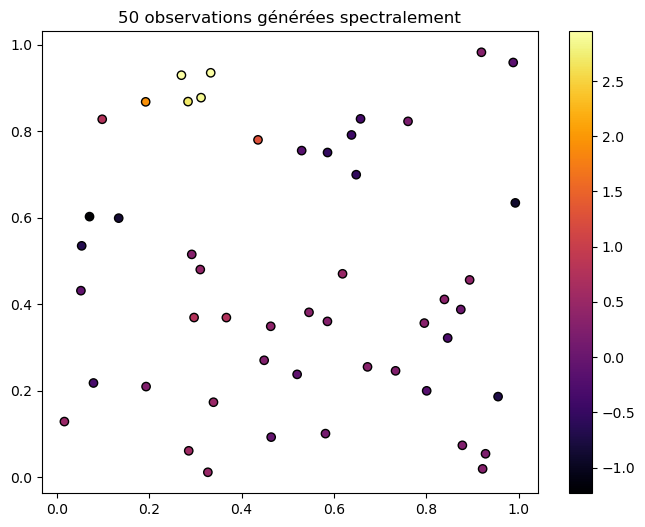

In [43]:
n = 50
sigma2 = 1.0
a = 0.05

X_1 = np.random.uniform(0,1,size=(n,2))
N = 500  
W = np.random.normal(0, np.sqrt(2/a), size=(N, 2))
Phi = np.random.uniform(0, 2*np.pi, size=N)

x_1 = np.zeros(n)
for i in range(n):
    x_1[i] = np.sqrt(2*sigma2/N) * np.sum(np.cos(np.dot(W, X_1[i].T) + Phi), axis=0)

D11 = distance_matrix(X_1,X_1)
K11 = covariance_gaussienne(D11,sigma2,a)
 
plt.figure(figsize=(8, 6))
plt.scatter(X_1[:, 0], X_1[:, 1], c=x_1, cmap='inferno', edgecolors='k')
plt.colorbar()
plt.title("50 observations générées spectralement")
plt.show()


3. Calculer l'espérance conditionnelle aux points de la grille et la représenter.

NB : Pour assurer la stabilité numérique, on doit ajouter un terme de régularisation plus important à la diagonale de la matrice de covariance avant de calculer son inverse ($10^{-2} I$ conviendra ici).

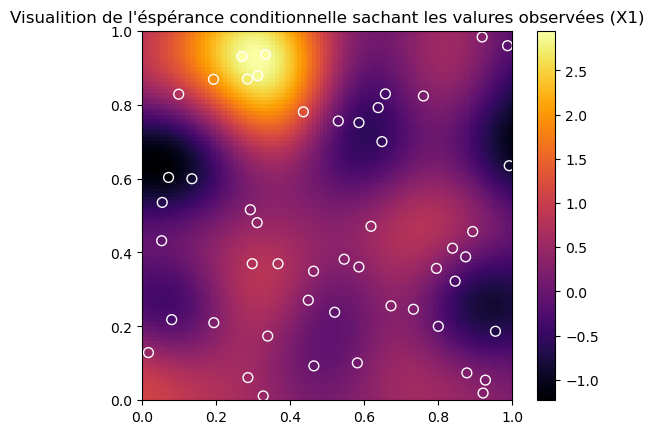

In [ ]:
pas = 100
x = np.linspace(0, 1, pas)
y = np.linspace(0, 1, pas)
X, Y = np.meshgrid(x, y)

M_pts_grille = np.column_stack((X.flatten(), Y.flatten()))

D21 = distance_matrix(M_pts_grille, X_1)
K21 = covariance_gaussienne(D21, sigma2, a)

# E[X2|X1] = K21 @ K11^{-1} @ x_1
esp_cond = K21 @ np.linalg.solve(K11 + 1e-2 * np.eye(n), x_1)  # on utilise solve à la place de invert pour plus de stabilité numérique

plt.figure()
plt.imshow(esp_cond.reshape(pas, pas), extent=[0, 1, 0, 1], origin='lower', cmap='inferno')

plt.scatter(X_1[:, 0], X_1[:, 1], c=x_1, edgecolors='white', s=50, cmap='inferno')

plt.colorbar()
plt.title("Visualition de l'éspérance conditionnelle sachant les valures observées (X1)")
plt.show()

4. Pour générer de manière indépendante la différence entre l'espérance conditionnelle et le vecteur des points non observés, on génère une seconde réalisation du champ aléatoire aux points de la grille **et** aux coordonnées des points observés par la méthode spectrale. On calcule ensuite la différence entre cette réalisation et l'espérance conditionnelle sachant les valeurs simulées aux coordonnées des points observés. Enfin, on additionne cette différence à l'espérance conditionnelle sachant les observations pour obtenir une réalisation conditionnelle du champ aléatoire Gaussien sur la grille. Implémenter cette approche et représenter une réalisation conditionnelle du champ aléatoire Gaussien sur la grille.

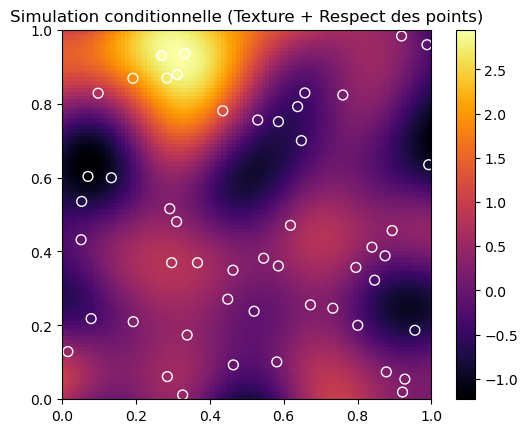

In [ ]:
sigma2 = 1.0
a = 0.05
N_sim = 500

W_sim = np.random.normal(0, np.sqrt(2/a), size=(N_sim, 2))
Phi_sim = np.random.uniform(0, 2*np.pi, size=N_sim)

# On simule les valeurs de Z pour les points de la grille
Z_sim_grille_val = np.zeros(pas**2)
for i in range(pas**2):
    Z_sim_grille_val[i] = np.sqrt(2*sigma2/N_sim) * np.sum(np.cos(np.dot(W_sim, M_pts_grille[i]) + Phi_sim))

# On simule aussi les valeurs de X1 pour les mêmes W_sim et Phi_sim
x1_sim = np.zeros(n)
for i in range(n):
    x1_sim[i] = np.sqrt(2*sigma2/N_sim) * np.sum(np.cos(np.dot(W_sim, X_1[i]) + Phi_sim))

esp_cond_sim = K21 @ np.linalg.solve(K11 + 1e-2 * np.eye(n), x1_sim)

# on applique la formule de l'énoncé
Z_final = esp_cond + (Z_sim_grille_val - esp_cond_sim)

plt.figure()
plt.imshow(Z_final.reshape(pas, pas), extent=[0, 1, 0, 1], origin='lower', cmap='inferno')
plt.scatter(X_1[:, 0], X_1[:, 1], c=x_1, edgecolors='white', s=50, cmap='inferno', label="Observations")
plt.colorbar()
plt.title("Simulation conditionnelle (Texture + Respect des points)")
plt.show()

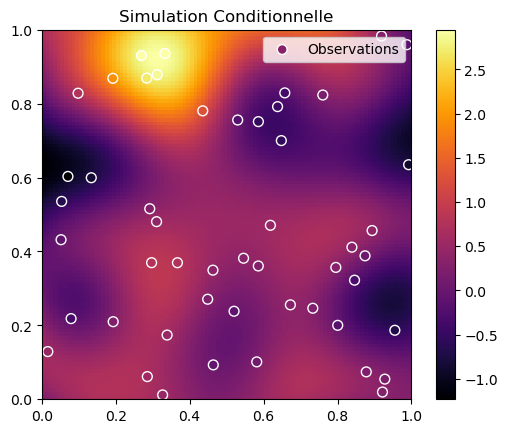

In [ ]:
def champ_gaussien_grille(L_x, L_y, W, Phi):
    N = W.shape[0]    
    X, Y = np.meshgrid(L_x, L_y)

    Wx = W[:, 0].reshape(-1, 1, 1)
    Wy = W[:, 1].reshape(-1, 1, 1)
    P  = Phi.reshape(-1, 1, 1)
    
    argument = (Wx * X) + (Wy * Y) + P
    
    somme = np.sum(np.cos(argument), axis=0)
    
    return np.sqrt(2/N) * somme

def champ_gaussien_points(Points_Coords, W, Phi):
    N = W.shape[0]

    argument = np.dot(W, Points_Coords.T) + Phi
    
    somme = np.sum(np.cos(argument), axis=0)
    
    return np.sqrt(2/N) * somme

# on lance la simulation
N_sim = 500
a = 0.05
L_x = np.linspace(0, 1, 100)
L_y = np.linspace(0, 1, 100)

# on génére W et phi pour toute la simulation (grille + points observés)
W_fixe = np.random.normal(0, np.sqrt(2/a), size=(N_sim, 2))
Phi_fixe = np.random.uniform(0, 2*np.pi, size=(N_sim,1))

# Simulation non-conditionnelle de la grille
S_grille = champ_gaussien_grille(L_x, L_y, W_fixe, Phi_fixe)

# Idem aux points observés
S_obs = champ_gaussien_points(X_1, W_fixe, Phi_fixe)

# Moyenne conditionnelle des points simulés
esp_cond_sim = K21 @ np.linalg.solve(K11 + 1e-2 * np.eye(len(x_1)), S_obs) 

# On calcule les valeurs conditionnelles sur la grille
S_grille_flat = S_grille.flatten()

# On applique la formule de l'énoncé
Z_conditionnel = esp_cond + (S_grille_flat - esp_cond_sim)

plt.figure()
plt.imshow(Z_conditionnel.reshape(100, 100), origin='lower', extent=[0,1,0,1], cmap='inferno')
plt.scatter(X_1[:,0], X_1[:,1], c=x_1, edgecolors='white', s=50, label='Observations', cmap='inferno')
plt.colorbar()
plt.title("Simulation Conditionnelle")
plt.legend()
plt.show()

5. Générer 500 simulations conditionnelles et comparer la moyenne empirique de ces simulations avec l'espérance conditionnelle calculée précédemment. Que constate-t-on ? Expliquer pourquoi.

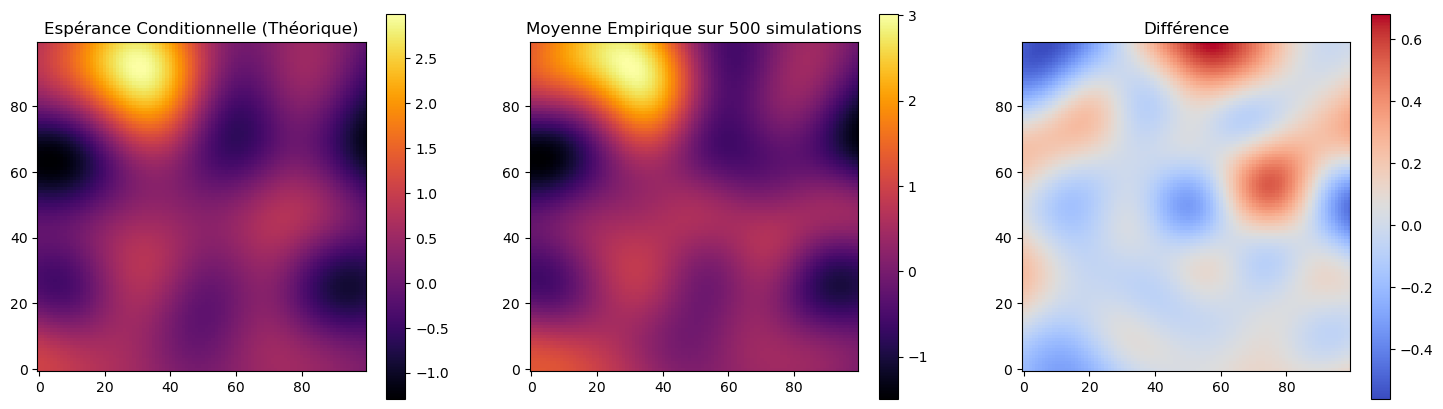

Erreur moyenne absolue : 0.116738


In [ ]:
# Paramètres
n_sim_cond = 500
Z_cond_sum = np.zeros(pas**2)
L_x = np.linspace(0, 1, pas)
L_y = np.linspace(0, 1, pas)

for i in range(n_sim_cond):
    W_fixe = np.random.normal(0, np.sqrt(2/a), size=(N_sim, 2))
    Phi_fixe = np.random.uniform(0, 2*np.pi, size=(N_sim,1))
    
    # Simulation non-conditionnelle de la grille
    S_grille = champ_gaussien_grille(L_x, L_y, W_fixe, Phi_fixe)
    # Idem aux points observés
    S_obs = champ_gaussien_points(X_1, W_fixe, Phi_fixe)

    # On calcule l'espérance conditionnelle pour cette simulation
    Z_cond = S_grille.flatten() + K21 @ np.linalg.solve(K11 + 1e-2 * np.eye(len(x_1)), x_1 - S_obs)
    
    Z_cond_sum += Z_cond

# On calcule la moyenne empirique
moyenne_empirique = Z_cond_sum / n_sim_cond

# Visualisation
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Espérance conditionnelle théorique
im0 = ax[0].imshow(esp_cond.reshape(pas, pas), origin='lower', cmap='inferno')
ax[0].set_title("Espérance Conditionnelle (Théorique)")
plt.colorbar(im0, ax=ax[0])

# Moyenne empirique des 500 simulations
im1 = ax[1].imshow(moyenne_empirique.reshape(pas, pas), origin='lower', cmap='inferno')
ax[1].set_title(f"Moyenne Empirique sur {n_sim_cond} simulations")
plt.colorbar(im1, ax=ax[1])

# Différence
diff = (esp_cond - moyenne_empirique).reshape(pas, pas)
im2 = ax[2].imshow(diff, origin='lower', cmap='coolwarm')
ax[2].set_title("Différence")
plt.colorbar(im2, ax=ax[2])

plt.show()

print(f"Erreur moyenne absolue : {np.mean(np.abs(diff)):.6f}")

# Simulation non-stationnaire

On souhaite désormais simuler un champ aléatoire Gaussien non-stationnaire, c'est-à-dire dont la fonction de covariance dépend de la position dans le domaine. Ces modèles plus complexes offrent une plus grande flexibilité pour modéliser des phénomènes naturels. En particulier, on va chercher à faire varier la valeur du paramètre d'échelle $a$ en fonction de la position. On considère une fonction de covariance de la forme :
$$C(x, y) = 2\frac{\sqrt{a(x) a(y)}}{a(x)+a(y)} \exp\left(-\frac{2\|x - y\|^2}{a(x)+a(y)}\right),$$
où $a : [0,1]^2 \to \mathbb{R}_+^*$ est une fonction définissant le paramètre d'échelle en chaque point du domaine.

Pour générer des réalisations de ce champ aléatoire non-stationnaire, on peut adapter la méthode spectrale en utilisant une approche locale. Précisément, on va considérer la modification suivante de la méthode spectrale :

$$Z(x) = \sqrt{\frac{2f_x(W)}{g(W)}}\cos(\langle W, x \rangle + \Phi)$$

où $W$ et $\Phi$ sont deux variables aléatoires indépendantes, de lois respectives $\mathcal{N}(0, \frac{2}{a} I_2)$ et $\mathcal{U}[0, 2\pi[$, et où $f_x$ est la densité de la loi $\mathcal{N}(0, \frac{2}{a(x)} I_2)$ et $g$ est la densité de la loi $\mathcal{N}(0, \frac{2}{a} I_2)$ pour $a = \inf_{x \in [0,1]^2} a(x)>0$, avec $a>0$.

1. Justifier que cette modification permet de simuler un champ aléatoire Gaussien non-stationnaire avec la fonction de covariance donnée précédemment. Quelle technique de simulation vue en cours est-elle utilisée ici ?

La modification proposée repose sur la technique de l'échantillonnage préférentiel (Importance Sampling) appliquée à la représentation spectrale.

La méthode spectrale pour un champ stationnaire utilise la formule : $Z(x) = \sqrt{\frac{2}{M}} \sum_{k=1}^{N} \cos(\langle \omega_k, x \rangle + \phi_k)$ 

Où les fréquences $\omega_k$ sont tirées selon la densité spectrale cible $f(\omega)$. Pour un champ non-stationnaire, la densité spectrale cible $f_x(\omega)$ dépend de la position $x$ ! 

Il est impossible de tirer un ensemble unique de fréquences $\omega_k$ qui suive simultanément toutes les densités $f_x$ locales.

On tire donc les fréquences selon une densité globale $g(\omega)$ (avec le spectre le plus large correspondant à $a_{min}$). 

Ensuite, on corrige ce tirage localement en introduisant un poids dans l'amplitude :$\sqrt{\frac{f_x(\omega_k)}{g(\omega_k)}}$

Vérifions que la méthode fonctionne : 

- Calcul de l'espérance : 

Comme avant on a par formule de trigonométrie :
$$E[Z(x)] = E\left[\sqrt{\frac{2f_x(W)}{g(W)}} \cdot [ \cos(\langle W, x \rangle)\cos(\Phi) - \sin(\langle W, x \rangle)\sin(\Phi)]\right]$$

Par linéarité et indépendance de $W$ et $\Phi$:
$$E[Z(x)] = E\left[\sqrt{\frac{2f_x(W)}{g(W)}} \cos(\langle W, x \rangle)\right] E[\cos(\Phi)] - E\left[\sqrt{\frac{2f_x(W)}{g(W)}} \\sin(\langle W, x \rangle) \right] E[\sin(\Phi)] $$

Comme $ E[\cos(\Phi)] = E[\sin(\Phi)] = 0$ : 
$$ E[Z(x)] = 0$$

- Calcul de la variance :

Comme il a été fait dans une partie précédente en la formule de trigo $\cos(a)\cos(b) = \frac{1}{2}(\cos(a+b) + \cos(a-b))$, puisque le terme avec $ + 2\Phi$ est nul:
$$E[Z(x)Z(y)] = E\left[ \frac{2\sqrt{f_x(W) f_y(W)}}{g(W)} \cdot \frac{1}{2} \cos(\langle W, x - y \rangle) \right]$$

$$E[Z(x)Z(y)] = \int_{\mathbb{R}^2} \frac{\sqrt{f_x(w) f_y(w)}}{g(w)} \cos(\langle w, x - y \rangle) g(w) dw$$

$$E[Z(x)Z(y)] = \int_{\mathbb{R}^2} \sqrt{f_x(w) f_y(w)} \cos(\langle w, x - y \rangle) dw$$

Ensuite, comme $f_x(w) = \frac{a(x)}{4\pi} \exp\left(-\frac{a(x)}{4} \|w\|^2\right)$ :
$$\sqrt{f_x(w) f_y(w)} = \sqrt{\frac{a(x)}{4\pi} \frac{a(y)}{4\pi}} \exp\left(-\frac{1}{2} \left[ \frac{a(x)}{4} + \frac{a(y)}{4} \right] \|w\|^2\right) = \frac{\sqrt{a(x)a(y)}}{4\pi} \exp\left(-\frac{a(x)+a(y)}{8} \|w\|^2\right)$$

En posant $K = 2 \frac{\sqrt{a(x)a(y)}}{a(x)+a(y)}$, ceci se réécrit :
$$\sqrt{f_x(w) f_y(w)} = K \frac{a(x)+a(y)}{8\pi} \exp\left(-\frac{a(x)+a(y)}{8} \|w\|^2\right)$$

Donc :
$$E[Z(x)Z(y)] = K \int_{\mathbb{R}^2} \frac{a(x)+a(y)}{8\pi} \exp\left(-\frac{a(x)+a(y)}{8} \|w\|^2\right) \cos(\langle w, x - y \rangle) \, dw$$

Puisque $\exp\left(-\frac{a(x)+a(y)}{8} \|w\|^2\right)$ est paire, l'intégrale du sinus est nulle, on eput donc passer en complexe : 
$$E[Z(x)Z(y)] = K \int_{\mathbb{R}^2} \frac{a(x)+a(y)}{8\pi} \exp\left(-\frac{a(x)+a(y)}{8} \|w\|^2\right) e^{i\langle w, x - y \rangle} \, dw$$

On reconnait la fonction caractérique de $U \sim \mathcal{N}(0, \frac{4}{a(x)+a(y)} I_2)$, donc : 
$$E[Z(x)Z(y)] = K \cdot E\left[ e^{i\langle U, x - y \rangle} \right]$$
$$E[Z(x)Z(y)] = K \cdot \exp\left(-\frac{2\|x-y\|^2}{a(x)+a(y)}\right)$$

Donc finalement, on a bien :
$$Cov(Z(x),Z(y)) = E[Z(x)Z(y)] = 2\frac{\sqrt{a(x) a(y)}}{a(x)+a(y)} \exp\left(-\frac{2\|x - y\|^2}{a(x)+a(y)}\right) = C(x, y)$$

2. Implémenter cette méthode pour simuler un champ aléatoire Gaussien non-stationnaire sur une grille régulière de points dans le domaine  $[0, 1] \times [0, 1]$. On choisira, par exemple, une fonction $a(x)$ variant linéairement selon l'axe des ordonnées entre deux valeurs $a_{min}=0.01$ et $a_{max}=0.1$ sur le domaine. Commenter les résultats obtenus.

Notons que : $\sqrt{\frac{2f_x(W)}{g(W)}} = \sqrt{\frac{2a(x)}{a}} \exp\left( -\frac{a(x) - a}{8} \|W\|^2 \right)$

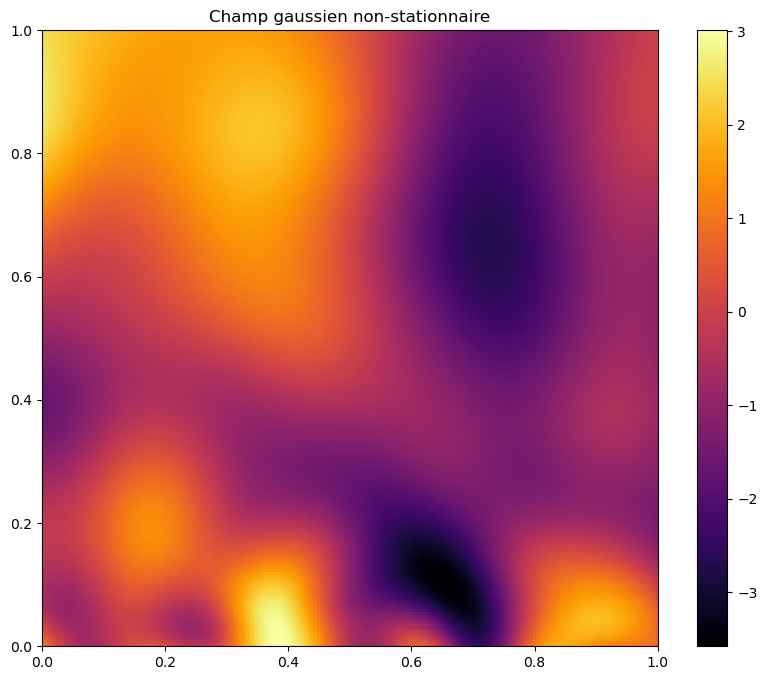

In [70]:
pas = 200           
M = 2000           
M = 2000           
a_min = 0.01       
a_max = 0.1        

x = np.linspace(0, 1, pas)
y = np.linspace(0, 1, pas)
X, Y = np.meshgrid(x, y)

# a varie linéairement selon l'axe y (axe vertical)
A = a_min + (a_max - a_min) * Y

# Tirage des fréquences et phases
W = np.sqrt(2 / a_min) * np.random.randn(M, 2)  
Phi = np.random.uniform(0, 2*np.pi, size=M)

Z = np.zeros((pas, pas))

# Calcul norme au carré des fréquences pour le poids
norm_W = np.sum(W**2, axis=1)

# On somme sur tous les modes 
for k in range(M):
    argument = W[k, 0] * X + W[k, 1] * Y + Phi[k]
    
    # Calcul du poids
    poids = np.sqrt(2*A / a_min) * np.exp( - (norm_W[k] / 8.0) * (A - a_min) )
    
    Z += poids * np.cos(argument)

Z = np.sqrt(2 / M) * Z

# Graphique
plt.figure(figsize=(10, 8))
plt.title(f"Champ gaussien non-stationnaire")
plt.imshow(Z, origin='lower', extent=[0, 1, 0, 1], cmap='inferno')
plt.colorbar()

plt.show()

On observe que pour y petit, donc a petit, il y a de fortes variations, et qu'à l'inverse pour y proche de 1, a est grand et donc les variations sont faibles, les "tâches sont plus grosses". 